In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-cases/S1. Curated Input.csv
/kaggle/input/test-cases/S2. Example Input.csv
/kaggle/input/xai-dataset-2/Clinical_Mastitis_cows_version2.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-06-25 13:28:23.687743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 13:28:23.687888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 13:28:23.846756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [3]:
# Load the dataset
file_path = "/kaggle/input/xai-dataset-2/Clinical_Mastitis_cows_version2.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset 

df = df.drop(columns=[ 'Day','Cow_ID'])
df = pd.get_dummies(df)

df

,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,class1,Breed_Jersey,Breed_hostlene
0,0,150,180,150,180,150,181,150,181,43,0,True,False
1,0,152,180,152,185,151,180,152,181,42,0,True,False
2,0,152,182,153,186,151,186,153,183,41,0,True,False
3,0,155,183,155,189,155,182,155,186,40,0,True,False
4,0,150,186,150,181,150,185,150,188,41,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,0,243,285,310,361,241,285,246,281,43,1,True,False
6596,0,240,276,315,358,242,285,247,284,43,1,True,False
6597,0,242,286,315,365,237,279,248,288,43,1,True,False
6598,0,245,285,314,361,239,280,241,288,43,1,True,False


In [5]:
df['Breed_Jersey'] = df['Breed_Jersey'].apply(lambda x: 1 if x else 0)
df['Breed_hostlene'] = df['Breed_hostlene'].apply(lambda x: 1 if x else 0)


y = df['class1'].values


x = df.drop('class1', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Previous_Mastits_status  6600 non-null   int64
 1   IUFL                     6600 non-null   int64
 2   EUFL                     6600 non-null   int64
 3   IUFR                     6600 non-null   int64
 4   EUFR                     6600 non-null   int64
 5   IURL                     6600 non-null   int64
 6   EURL                     6600 non-null   int64
 7   IURR                     6600 non-null   int64
 8   EURR                     6600 non-null   int64
 9   Temperature              6600 non-null   int64
 10  Breed_Jersey             6600 non-null   int64
 11  Breed_hostlene           6600 non-null   int64
dtypes: int64(12)
memory usage: 618.9 KB


,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Breed_Jersey,Breed_hostlene
0,0,150,180,150,180,150,181,150,181,43,1,0
1,0,152,180,152,185,151,180,152,181,42,1,0
2,0,152,182,153,186,151,186,153,183,41,1,0
3,0,155,183,155,189,155,182,155,186,40,1,0
4,0,150,186,150,181,150,185,150,188,41,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6595,0,243,285,310,361,241,285,246,281,43,1,0
6596,0,240,276,315,358,242,285,247,284,43,1,0
6597,0,242,286,315,365,237,279,248,288,43,1,0
6598,0,245,285,314,361,239,280,241,288,43,1,0


col:  Previous_Mastits_status


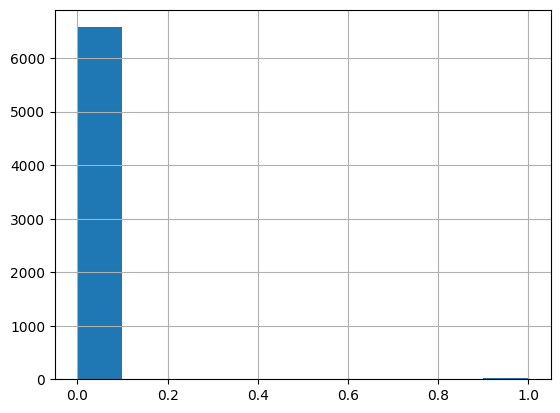

col:  IUFL


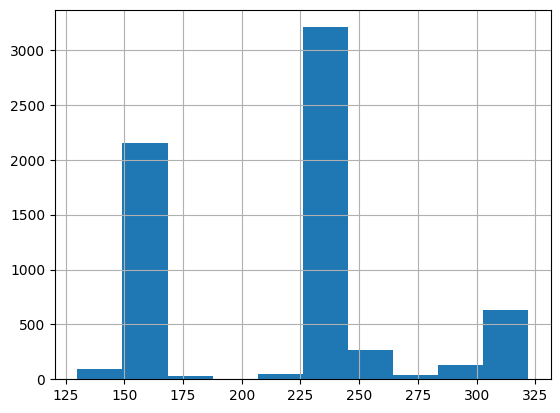

col:  EUFL


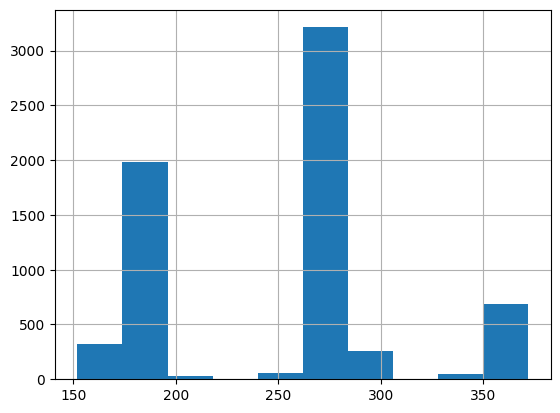

col:  IUFR


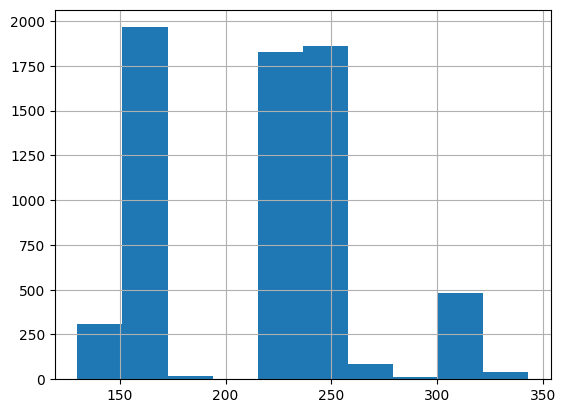

col:  EUFR


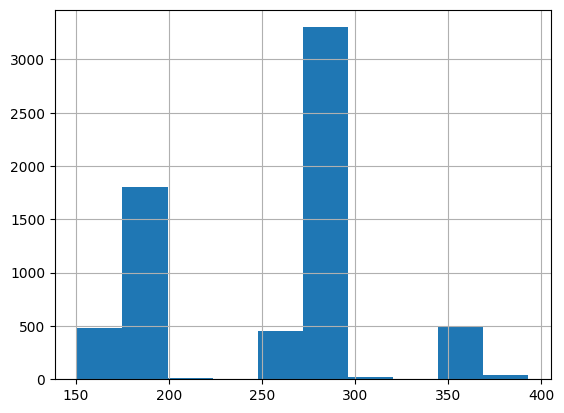

col:  IURL


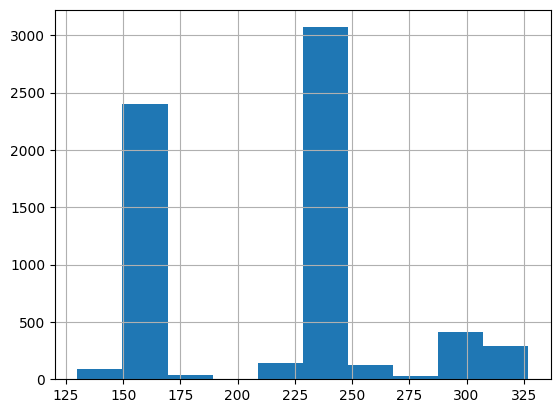

col:  EURL


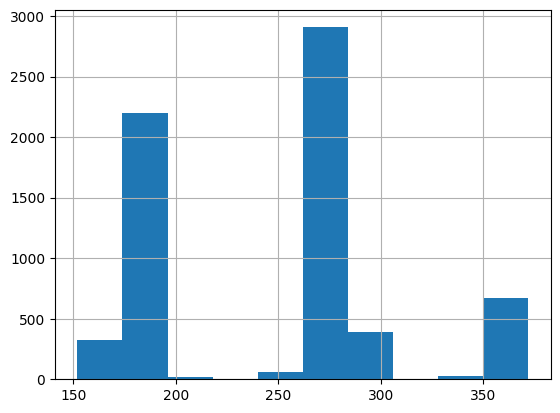

col:  IURR


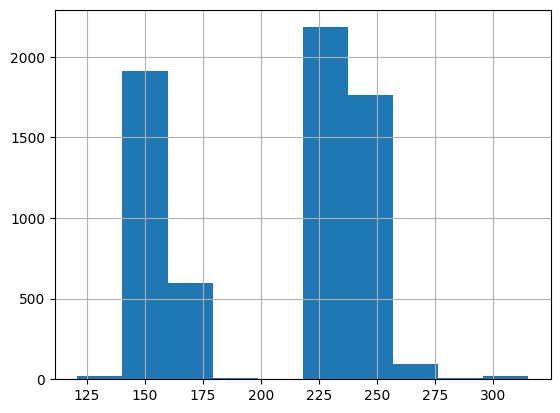

col:  EURR


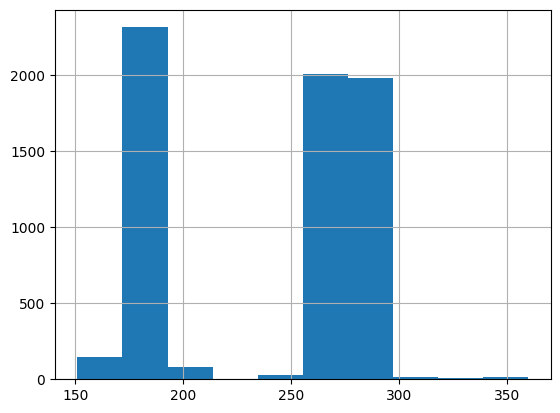

col:  Temperature


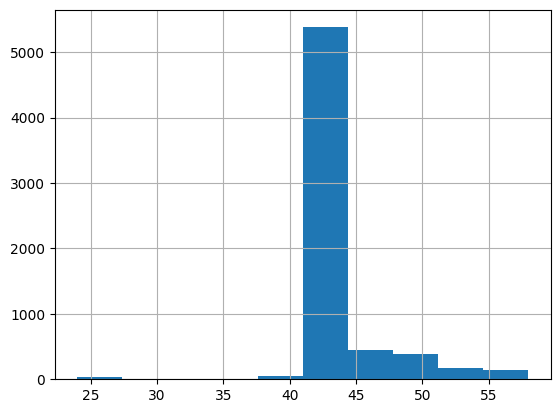

col:  class1


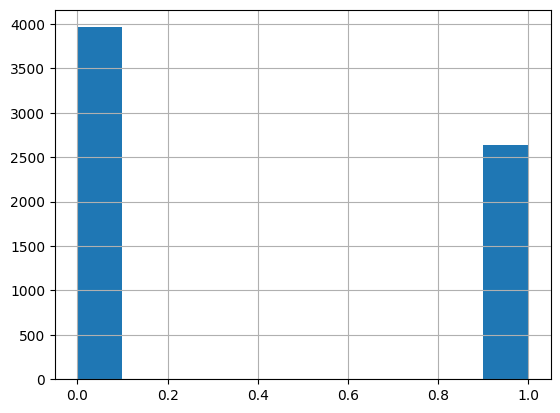

col:  Breed_Jersey


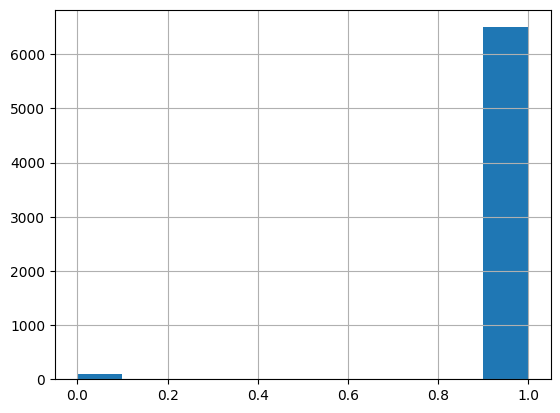

col:  Breed_hostlene


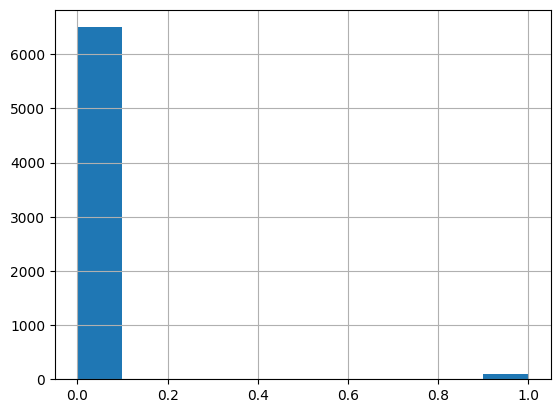

In [6]:
import matplotlib.pyplot as plt

columns = df.columns
for col in columns:
    print("col: ", col)
    df[col].hist()
    plt.show()

In [7]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 4620 or 70.0 %
Test set size: 1326 or 20.1 %
Validation set size: 654 or 9.9 %


In [8]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  0, 160, 181, ...,  43,   1,   0]],

       [[  0, 243, 279, ...,  43,   1,   0]],

       [[  0, 160, 192, ...,  43,   1,   0]],

       ...,

       [[  0, 164, 192, ...,  43,   1,   0]],

       [[  0, 232, 282, ...,  43,   1,   0]],

       [[  0, 231, 272, ...,  43,   1,   0]]])

# LSTM Model

In [9]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6764 - loss: 0.6082 - val_accuracy: 0.8884 - val_loss: 0.3947
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9054 - loss: 0.3405 - val_accuracy: 0.9021 - val_loss: 0.3099
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9002 - loss: 0.3053 - val_accuracy: 0.8945 - val_loss: 0.3208
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8973 - loss: 0.3029 - val_accuracy: 0.8807 - val_loss: 0.3191
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.3011 - val_accuracy: 0.8976 - val_loss: 0.3056
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9056 - loss: 0.2791 - val_accuracy: 0.9021 - val_loss: 0.3169
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9029 - loss: 0.2861 - val_accuracy: 0.9006 - val_loss: 0.3047
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9016 - loss: 0.2950 - val_accuracy: 0.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,555 (384.98 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,704 (256.66 KB)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.4542
Test Accuracy: 0.8159879446029663


In [14]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [15]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [16]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

     Previous_Mastits_status  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  EURR  \
648                        0   304   354   154   174   151   171   153   173   
467                        0   308   358   163   179   151   173   158   181   
115                        0   317   367   151   186   152   183   152   188   
224                        0   317   367   153   189   159   185   154   191   
111                        0   161   172   310   360   161   179   162   180   

     Temperature  Breed_Jersey  Breed_hostlene  Predicted Probability  \
648           47             1               0                    1.0   
467           47             1               0                    1.0   
115           52             1               0                    1.0   
224           52             1               0                    1.0   
111           45             1               0                    1.0   

     Actual Label  
648             1  
467             1  
115             1  


In [17]:
 top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of      Previous_Mastits_status  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  EURR  \
648                        0   304   354   154   174   151   171   153   173   
467                        0   308   358   163   179   151   173   158   181   
115                        0   317   367   151   186   152   183   152   188   
224                        0   317   367   153   189   159   185   154   191   
111                        0   161   172   310   360   161   179   162   180   

     Temperature  Breed_Jersey  Breed_hostlene  Predicted Probability  \
648           47             1               0                    1.0   
467           47             1               0                    1.0   
115           52             1               0                    1.0   
224           52             1               0                    1.0   
111           45             1               0                    1.0   

     Actual Label  
648             1  
467     

In [18]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [19]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Model Evaluation

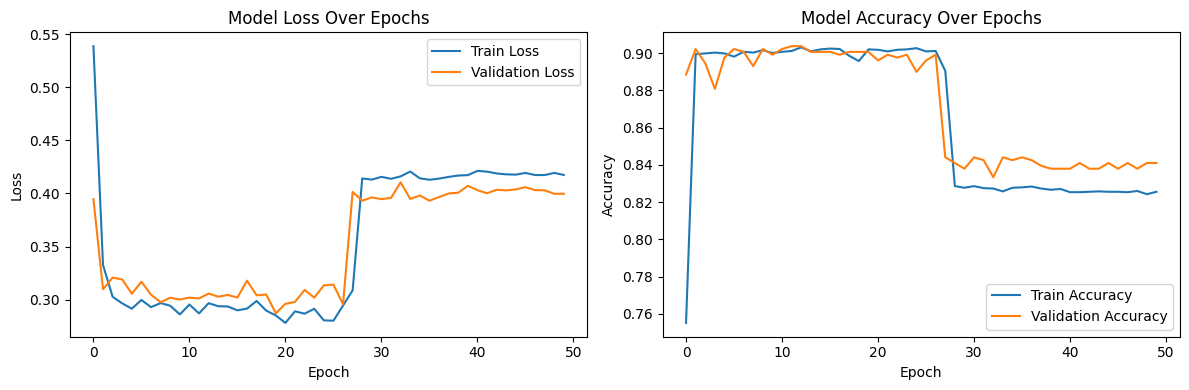

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

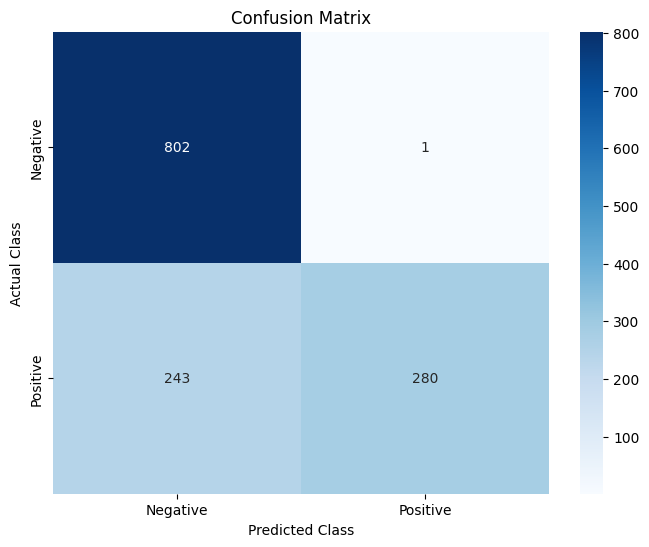

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8159879336349924
Precision: 0.99644128113879
Recall: 0.5353728489483748
F1 Score: 0.6965174129353233


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


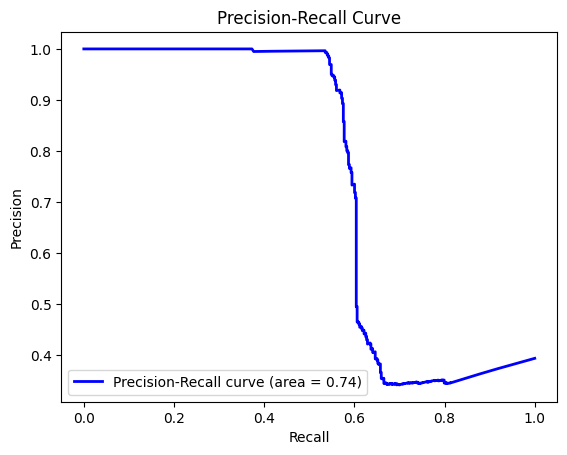

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()
# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute average precision score
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

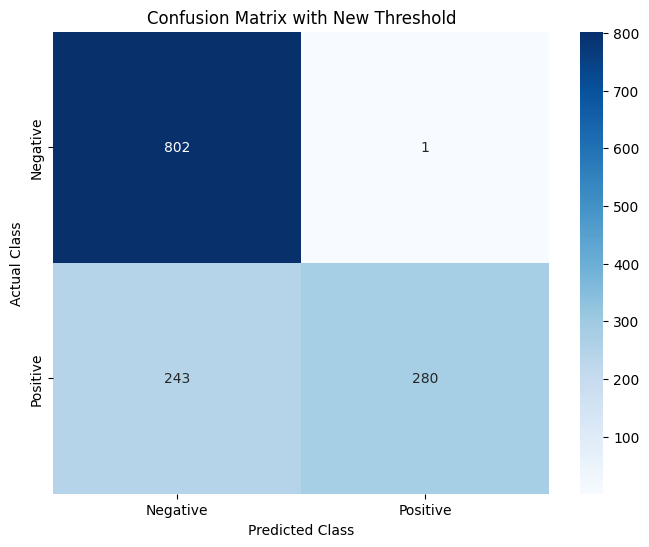

In [24]:
# Adjusting threshold to prioritize recall
new_threshold = 0.4
new_binary_predictions = (predictions > new_threshold).astype(int)
new_conf_matrix = confusion_matrix(y_test, new_binary_predictions)

# Redisplay new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with New Threshold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

True Negatives (TN): 802
False Positives (FP): 1
False Negatives (FN): 243
True Positives (TP): 280


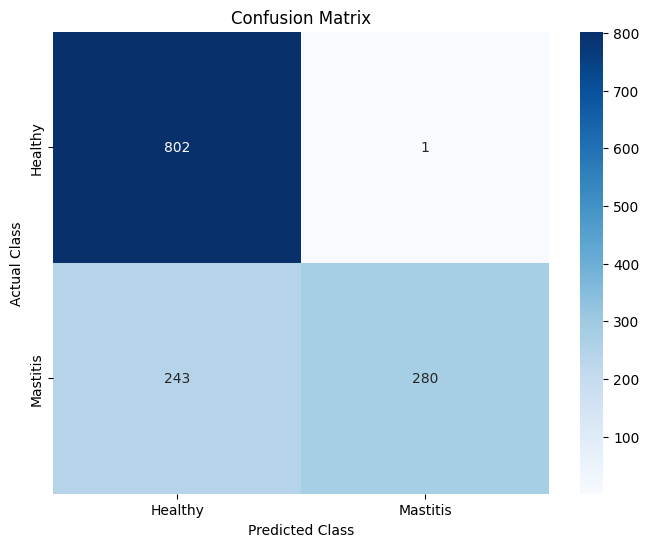

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Healthy', 'Mastitis'], yticklabels=['Healthy', 'Mastitis'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


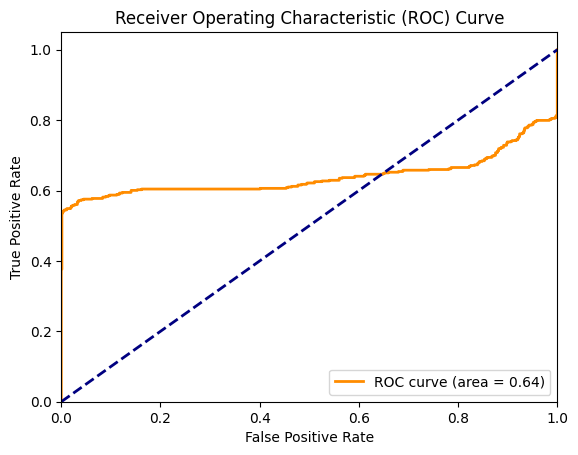

In [26]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
print(model.output_shape)

(None, 1)


In [28]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# SHAP Value Calculation and Visualization

In [29]:
X_train_flat = X_train.values
X_test_flat = X_test.values

In [30]:
def model_predict(data):
    reshaped_data = data.reshape(data.shape[0], 1, data.shape[1])
    return model.predict(reshaped_data)

In [31]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_flat, 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [32]:
shap_values = explainer.shap_values(X_test_flat[:20], nsamples=100)

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━

In [33]:
# Ensure that single_record_features is correctly shaped
single_record_features = X_test_flat[0]  # This assumes X_test_flat is (samples, features) and already 2D

# Check the shape or length
print("Features length:", len(single_record_features))

# Select SHAP values for a single record, assuming shap_values is a 2D array
single_record_shap_values = shap_values[0]
print("Correctly selected SHAP values length:", len(single_record_shap_values))

Features length: 12
Correctly selected SHAP values length: 20


In [34]:
explainer.expected_value

array([0.39285865])

In [35]:
single_record_features = X_test_flat[0] 
print("Features shape:", single_record_features.shape)

print("SHAP values:", single_record_shap_values)
print("Feature values:", single_record_features)


Features shape: (12,)
SHAP values: [[-9.08362037e-03 -9.67406292e-02  0.00000000e+00  0.00000000e+00
   2.18153218e-02  9.86148509e-03  2.91768224e-02 -6.82412193e-02
  -7.57396898e-02  1.92996633e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.11009095e-02 -2.10113704e-02  8.60241151e-02
   5.12562126e-01  2.90381713e-02  5.06482430e-02  0.00000000e+00
  -4.42438096e-02 -2.21633586e-02  0.00000000e+00  0.00000000e+00]
 [-1.11879293e-02  1.28875428e-01  0.00000000e+00 -2.49639415e-02
  -1.99629223e-01 -1.34254580e-01 -2.24478018e-01  1.52560727e-01
   9.80347034e-02  4.53487374e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.49849068e-03  0.00000000e+00
   3.94097107e-02  2.47267152e-01  3.32273238e-01  0.00000000e+00
  -2.34798561e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.03059205e-01  0.00000000e+00 -3.28544430e-02
  -1.78810981e-01 -1.42879101e-01 -2.19343417e-01  1.31810512e-01
   1.70905456e-01  0.00000000e+00  0.

In [36]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [37]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_1.html', shap_html)

In [38]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [39]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_2.html', shap_html)

In [40]:
shap_values

[array([[-9.08362037e-03, -9.67406292e-02,  0.00000000e+00,
          0.00000000e+00,  2.18153218e-02,  9.86148509e-03,
          2.91768224e-02, -6.82412193e-02, -7.57396898e-02,
          1.92996633e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.11009095e-02, -2.10113704e-02,
          8.60241151e-02,  5.12562126e-01,  2.90381713e-02,
          5.06482430e-02,  0.00000000e+00, -4.42438096e-02,
         -2.21633586e-02,  0.00000000e+00,  0.00000000e+00],
        [-1.11879293e-02,  1.28875428e-01,  0.00000000e+00,
         -2.49639415e-02, -1.99629223e-01, -1.34254580e-01,
         -2.24478018e-01,  1.52560727e-01,  9.80347034e-02,
          4.53487374e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  6.49849068e-03,
          0.00000000e+00,  3.94097107e-02,  2.47267152e-01,
          3.32273238e-01,  0.00000000e+00, -2.34798561e-02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.0305920

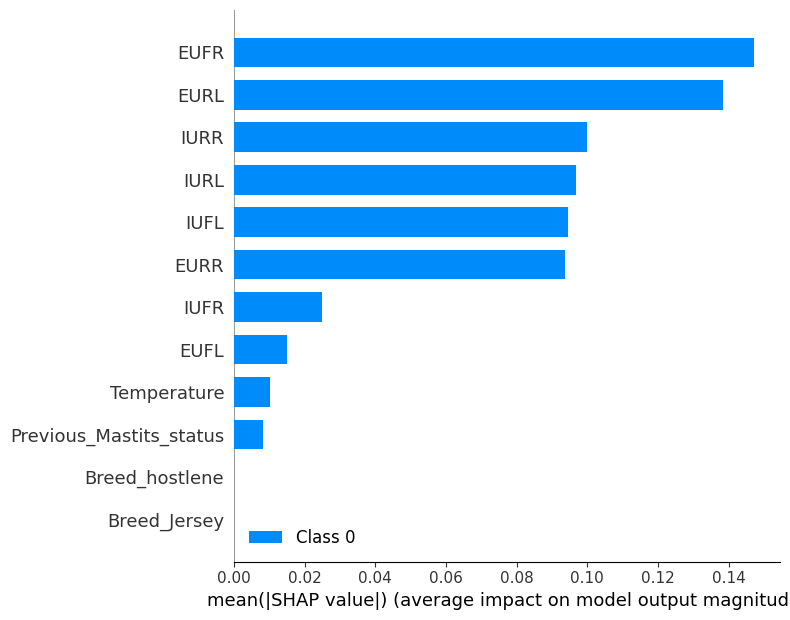

In [41]:
shap.summary_plot(
    shap_values,
    X_test_flat[:20],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)

In [42]:
top_5_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 648 to 111
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Previous_Mastits_status  5 non-null      int64  
 1   IUFL                     5 non-null      int64  
 2   EUFL                     5 non-null      int64  
 3   IUFR                     5 non-null      int64  
 4   EUFR                     5 non-null      int64  
 5   IURL                     5 non-null      int64  
 6   EURL                     5 non-null      int64  
 7   IURR                     5 non-null      int64  
 8   EURR                     5 non-null      int64  
 9   Temperature              5 non-null      int64  
 10  Breed_Jersey             5 non-null      int64  
 11  Breed_hostlene           5 non-null      int64  
 12  Predicted Probability    5 non-null      float32
 13  Actual Label             5 non-null      int64  
dtypes: float32(1), int64(13)
memory

In [43]:
X_sample_test = top_5_predictions.drop(columns=[ 'Predicted Probability','Actual Label'])
X_sample_test

,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Breed_Jersey,Breed_hostlene
648,0,304,354,154,174,151,171,153,173,47,1,0
467,0,308,358,163,179,151,173,158,181,47,1,0
115,0,317,367,151,186,152,183,152,188,52,1,0
224,0,317,367,153,189,159,185,154,191,52,1,0
111,0,161,172,310,360,161,179,162,180,45,1,0


In [44]:
Y_sample_test = top_5_predictions['Actual Label'].values
Y_sample_test

array([1, 1, 1, 1, 1])

In [45]:
X_test_flat[:20]
shap_values

[array([[-9.08362037e-03, -9.67406292e-02,  0.00000000e+00,
          0.00000000e+00,  2.18153218e-02,  9.86148509e-03,
          2.91768224e-02, -6.82412193e-02, -7.57396898e-02,
          1.92996633e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.11009095e-02, -2.10113704e-02,
          8.60241151e-02,  5.12562126e-01,  2.90381713e-02,
          5.06482430e-02,  0.00000000e+00, -4.42438096e-02,
         -2.21633586e-02,  0.00000000e+00,  0.00000000e+00],
        [-1.11879293e-02,  1.28875428e-01,  0.00000000e+00,
         -2.49639415e-02, -1.99629223e-01, -1.34254580e-01,
         -2.24478018e-01,  1.52560727e-01,  9.80347034e-02,
          4.53487374e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  6.49849068e-03,
          0.00000000e+00,  3.94097107e-02,  2.47267152e-01,
          3.32273238e-01,  0.00000000e+00, -2.34798561e-02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.0305920

In [46]:
X_sample_test_flat = X_sample_test.values
X_sample_test_flat

array([[  0, 304, 354, 154, 174, 151, 171, 153, 173,  47,   1,   0],
       [  0, 308, 358, 163, 179, 151, 173, 158, 181,  47,   1,   0],
       [  0, 317, 367, 151, 186, 152, 183, 152, 188,  52,   1,   0],
       [  0, 317, 367, 153, 189, 159, 185, 154, 191,  52,   1,   0],
       [  0, 161, 172, 310, 360, 161, 179, 162, 180,  45,   1,   0]])

In [47]:
shap_values_v1 = explainer.shap_values(X_sample_test_flat, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [48]:
shap_values_v1

[array([[ 0.        ,  0.17482472,  0.07336066,  0.        ,  0.        ,
          0.        ,  0.06890654,  0.14444859,  0.13751262,  0.00582926,
          0.        ,  0.        ],
        [ 0.        ,  0.2387836 ,  0.09214387,  0.        , -0.0575787 ,
          0.        ,  0.06732182,  0.13255873,  0.1679198 , -0.03626673,
          0.        ,  0.        ],
        [ 0.        ,  0.24521642,  0.0616568 , -0.03885494, -0.04566006,
          0.        ,  0.09634758,  0.12810245,  0.15807415,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.25039745,  0.12974413, -0.05233551, -0.09533812,
         -0.01397146,  0.07744784,  0.17852775,  0.13041031,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.09749764,  0.03000794,  0.12400791,  0.25179186,
         -0.03743967, -0.07959452,  0.10795986,  0.11286275,  0.        ,
          0.        ,  0.        ]])]

In [49]:
shap.initjs()
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [50]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_0.html', shap_html)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [52]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_1.html', shap_html)

In [53]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [54]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_2.html', shap_html)

In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [56]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_3.html', shap_html)

In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [58]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_4.html', shap_html)

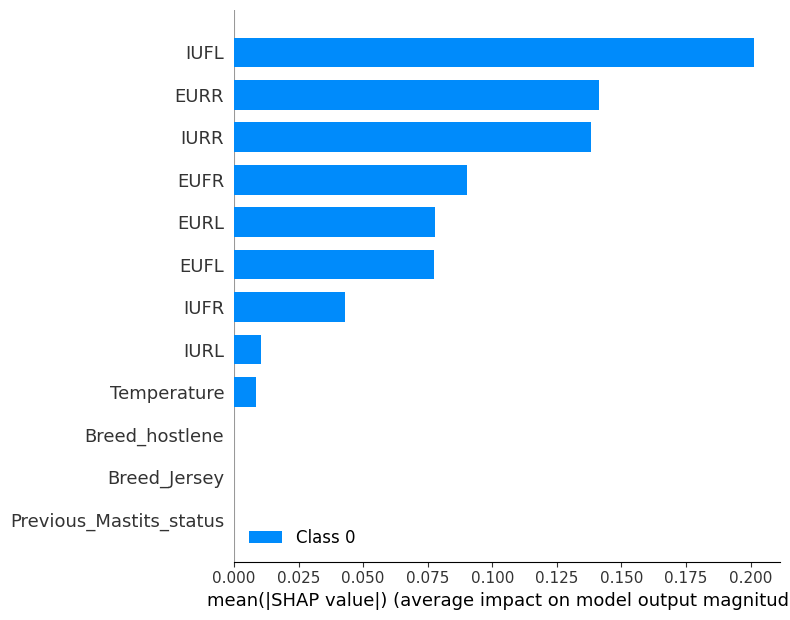

In [59]:
shap.summary_plot(
    shap_values_v1,
    X_sample_test_flat,
    feature_names=X_test.columns.tolist()[:15], 
)

In [60]:
shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

In [61]:
shap_html = shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/General_force_plot.html', shap_html)

In [62]:
shap.plots.force(explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

In [63]:
  shap_html = shap.force_plot(
    explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/top_5_predictions_force_plot_1.html', shap_html)

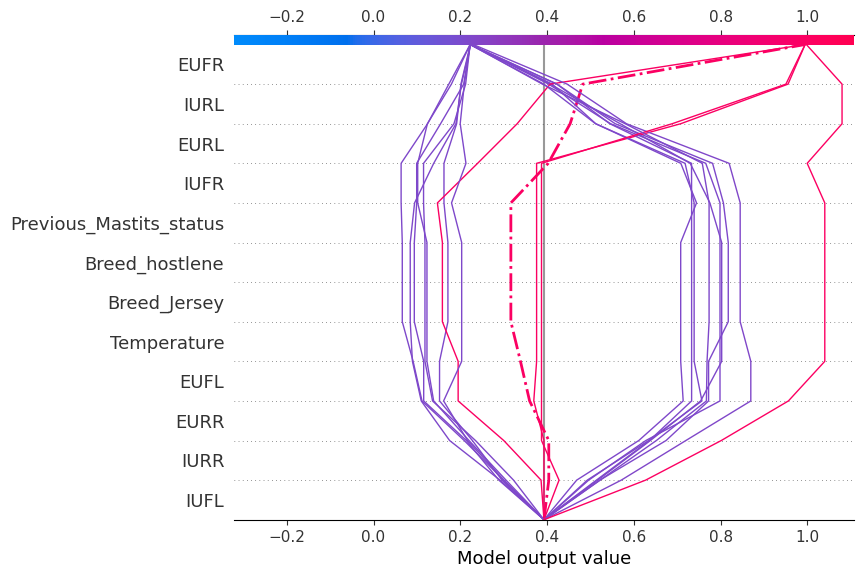

In [64]:
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names=X_test.columns.tolist(),link="identity", highlight=1,legend_location="best",
                  feature_order="hclust")

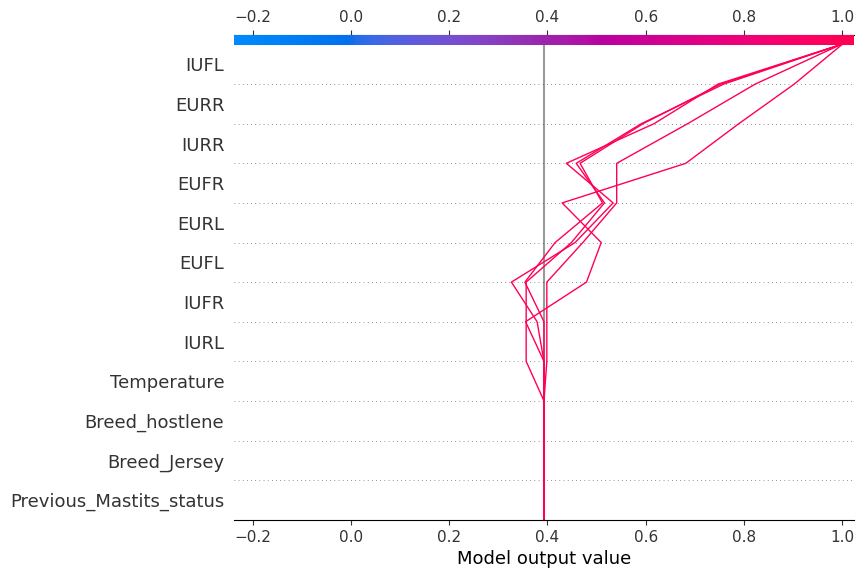

In [65]:
shap.decision_plot(explainer.expected_value, shap_values_v1[0], feature_names=X_test.columns.tolist(),)

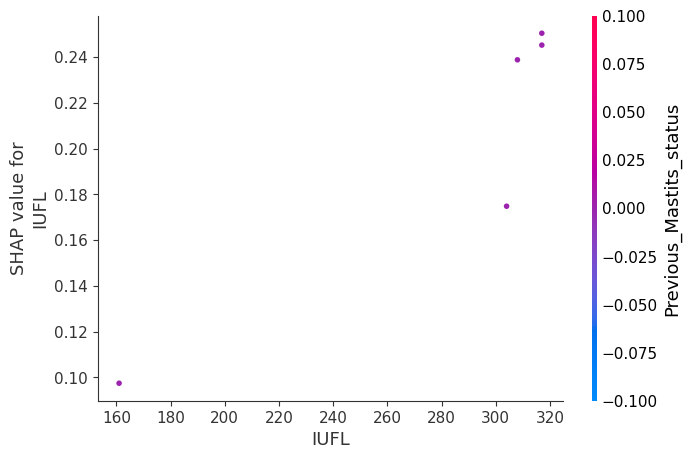

In [66]:
shap.dependence_plot(1, shap_values_v1[0], X_sample_test_flat,feature_names=X_test.columns.tolist())

In [67]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat = np.array(shap_values_v1).reshape((5, 12))
shap_values_flat


array([[ 0.        ,  0.17482472,  0.07336066,  0.        ,  0.        ,
         0.        ,  0.06890654,  0.14444859,  0.13751262,  0.00582926,
         0.        ,  0.        ],
       [ 0.        ,  0.2387836 ,  0.09214387,  0.        , -0.0575787 ,
         0.        ,  0.06732182,  0.13255873,  0.1679198 , -0.03626673,
         0.        ,  0.        ],
       [ 0.        ,  0.24521642,  0.0616568 , -0.03885494, -0.04566006,
         0.        ,  0.09634758,  0.12810245,  0.15807415,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.25039745,  0.12974413, -0.05233551, -0.09533812,
        -0.01397146,  0.07744784,  0.17852775,  0.13041031,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.09749764,  0.03000794,  0.12400791,  0.25179186,
        -0.03743967, -0.07959452,  0.10795986,  0.11286275,  0.        ,
         0.        ,  0.        ]])

In [68]:
import shap
shap_values_expl = shap.Explanation(values=shap_values_flat, base_values=explainer.expected_value, data=X_test_flat, feature_names=X_test.columns.tolist())


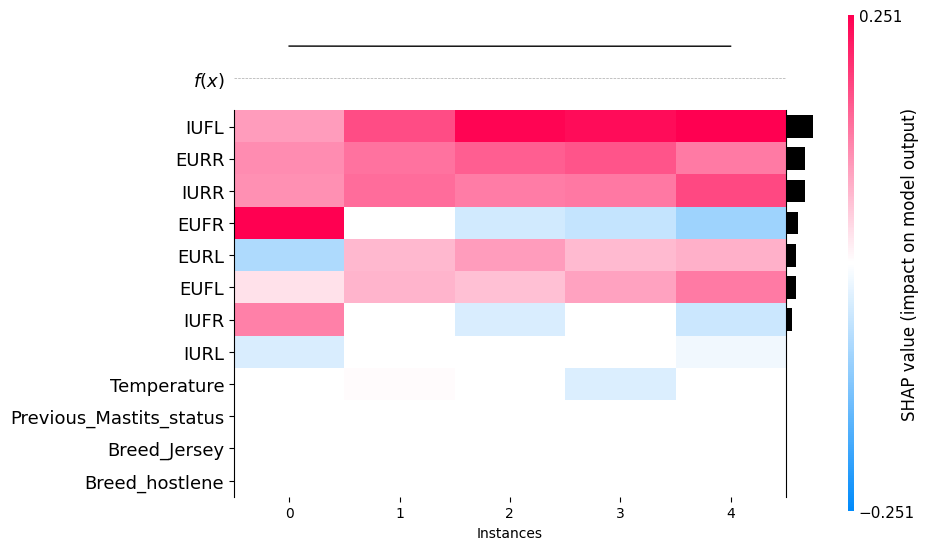

In [69]:
# Visualize SHAP values using heatmap
shap.plots.heatmap(shap_values_expl, max_display=15)

In [70]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat_1 = np.array(shap_values).reshape((20, 12))
shap_values_flat_1
shap_values_expl_1 = shap.Explanation(values=shap_values_flat_1, base_values=explainer.expected_value, data=X_test_flat[:20], feature_names=X_test.columns.tolist())


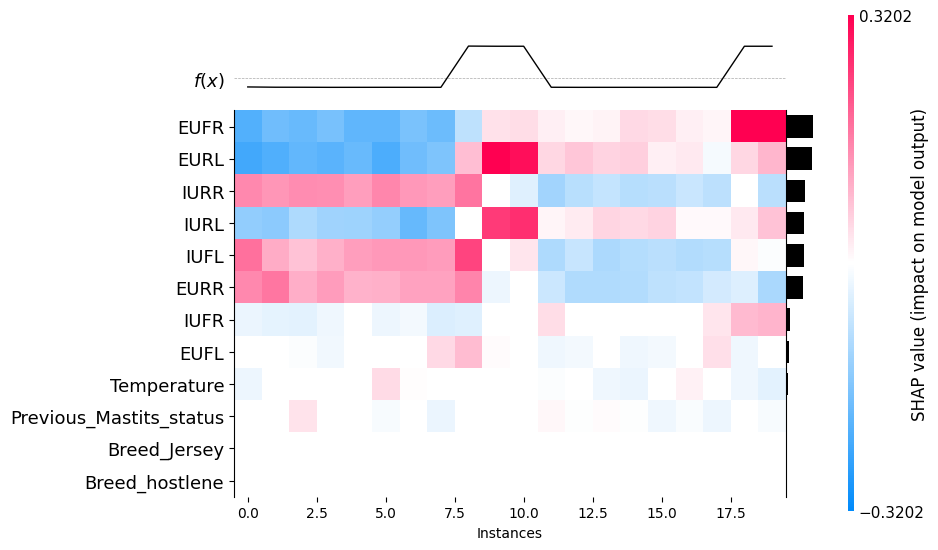

In [71]:
shap.plots.heatmap(shap_values_expl_1, max_display=15)

# Smooth Curve Model

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8246 - loss: 0.4166 - val_accuracy: 0.8366 - val_loss: 0.4028
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8226 - loss: 0.4265 - val_accuracy: 0.8366 - val_loss: 0.4031
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8178 - loss: 0.4313 - val_accuracy: 0.8344 - val_loss: 0.4058
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.4081 - val_accuracy: 0.8366 - val_loss: 0.4053
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.4240 - val_accuracy: 0.8366 - val_loss: 0.4023
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8275 - loss: 0.4211 - val_accuracy: 0.8366 - val_loss: 0.4047
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8312 - loss: 0.4143 - val_accuracy: 0.8366 - val_loss: 0.4076
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8258 - loss: 0.4181 - val_accuracy: 0.

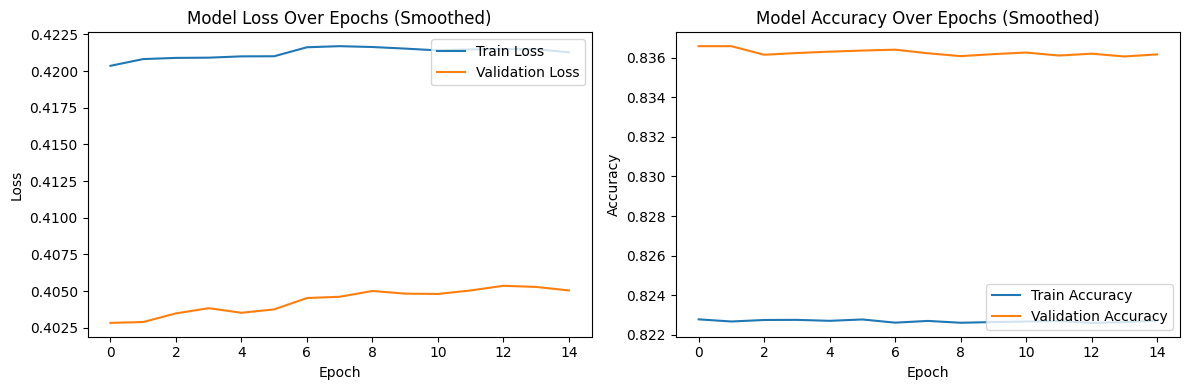

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8262 - loss: 0.4202 - val_accuracy: 0.8366 - val_loss: 0.4036 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8215 - loss: 0.4201 - val_accuracy: 0.8366 - val_loss: 0.4032 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8310 - loss: 0.4086 - val_accuracy: 0.8366 - val_loss: 0.4056 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8219 - loss: 0.4216 - val_accuracy: 0.8366 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8289 - loss: 0.4103 - val_accuracy: 0.8366 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.4133 - val_accuracy: 0.8377 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8214 - loss: 0.4227 - 

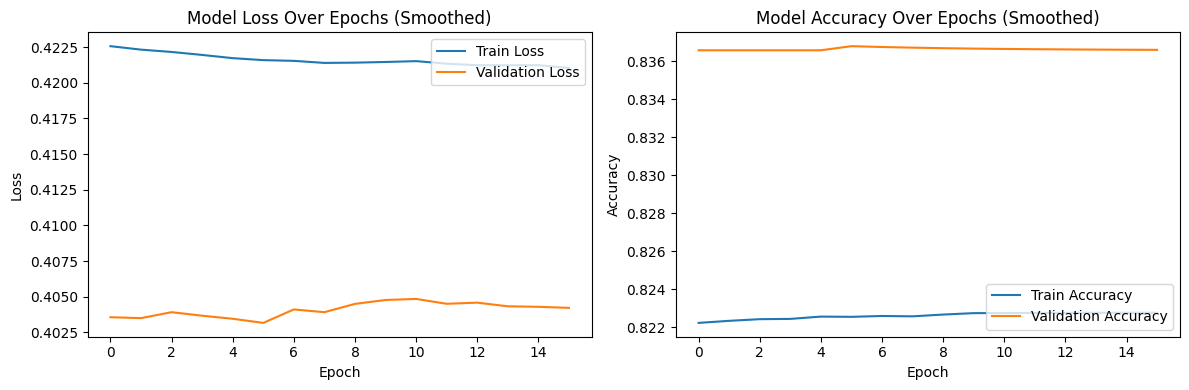

In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return  float(lr * tf.math.exp(-0.1).numpy())

# Implement learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


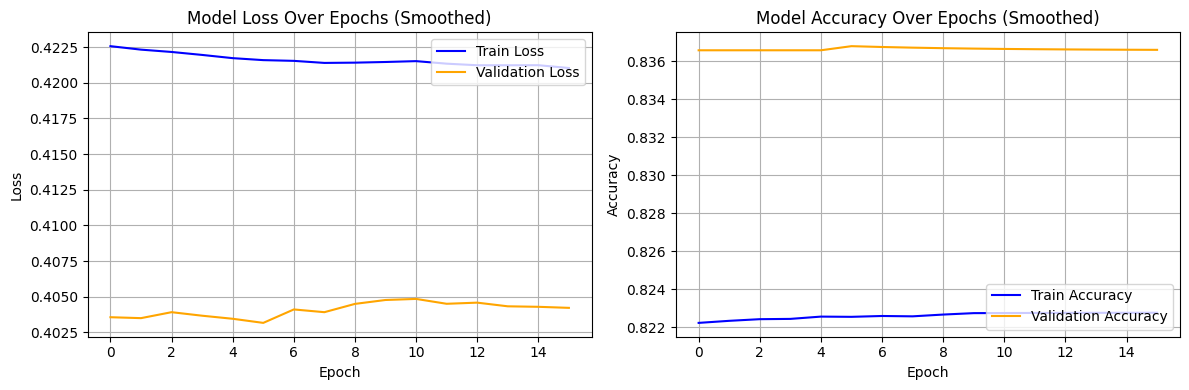

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Enhanced Plot for Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss', color='blue')
plt.plot(smooth_val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Enhanced Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy', color='blue')
plt.plot(smooth_val_acc, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()




)




# Mean Shap Values

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Assuming shap_values is the list of SHAP values you provided
shap_values = shap_values[0]  # Use the first element if shap_values is a list

# Calculate the mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

In [76]:
# Create a DataFrame for better visualization
feature_names = [
     'Previous Mastits status', 'IUFL', 'EUFL', 
    'IUFR', 'EUFR', 'IURL', 'EURL', 'IURR', 'EURR', 
    'Temperature',  'Breed Jersey', 'Breed hostlene'
]

mean_abs_shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP Value|': mean_abs_shap_values
}).sort_values(by='Mean |SHAP Value|', ascending=False)

# Display the DataFrame
print(mean_abs_shap_df)


                    Feature  Mean |SHAP Value|
4                      EUFR           0.147182
6                      EURL           0.138420
7                      IURR           0.099954
5                      IURL           0.096903
1                      IUFL           0.094584
8                      EURR           0.093609
3                      IUFR           0.024918
2                      EUFL           0.015013
9               Temperature           0.010201
0   Previous Mastits status           0.008084
10             Breed Jersey           0.000000
11           Breed hostlene           0.000000


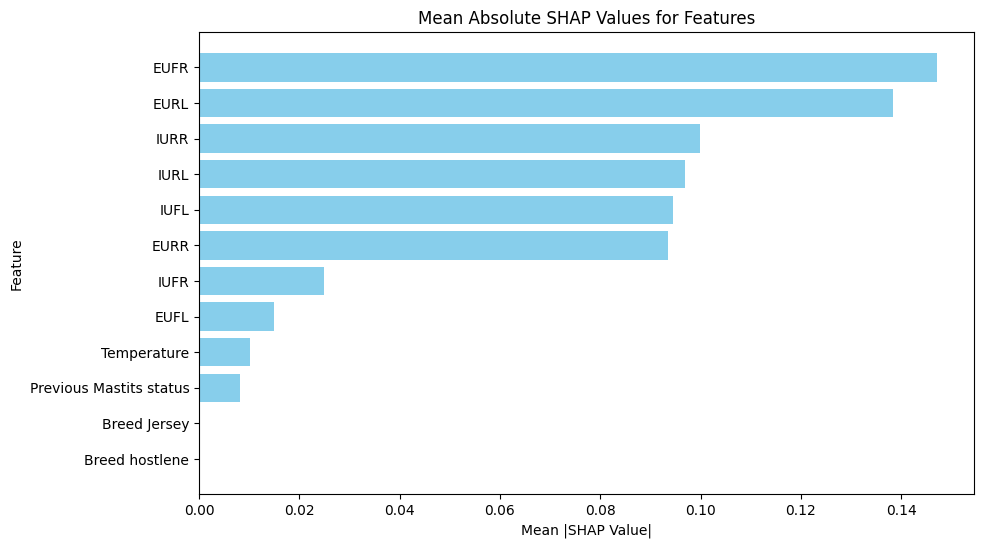

In [77]:
# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(mean_abs_shap_df['Feature'], mean_abs_shap_df['Mean |SHAP Value|'], color='skyblue')
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')
plt.title('Mean Absolute SHAP Values for Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


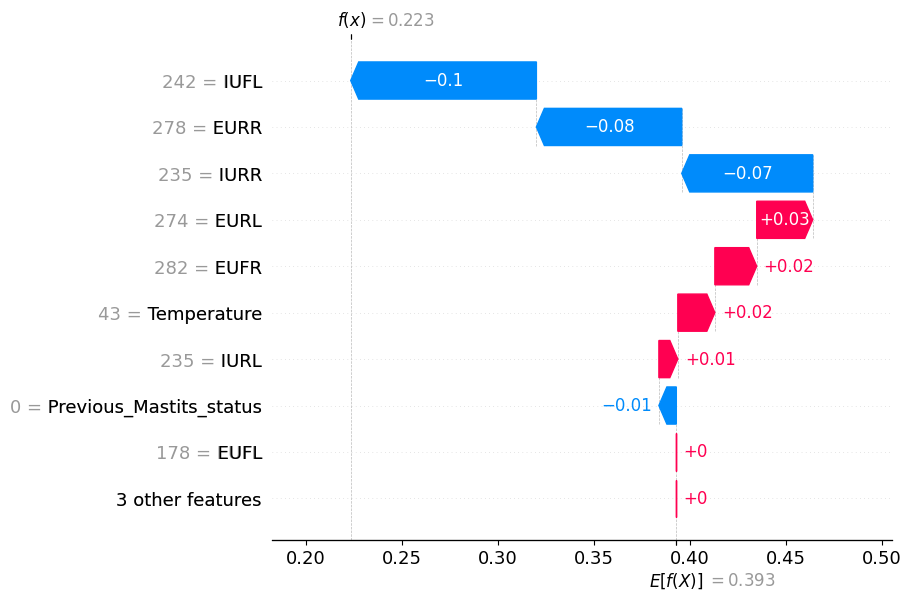

In [78]:
shap.plots.waterfall(shap_values_expl_1[0])

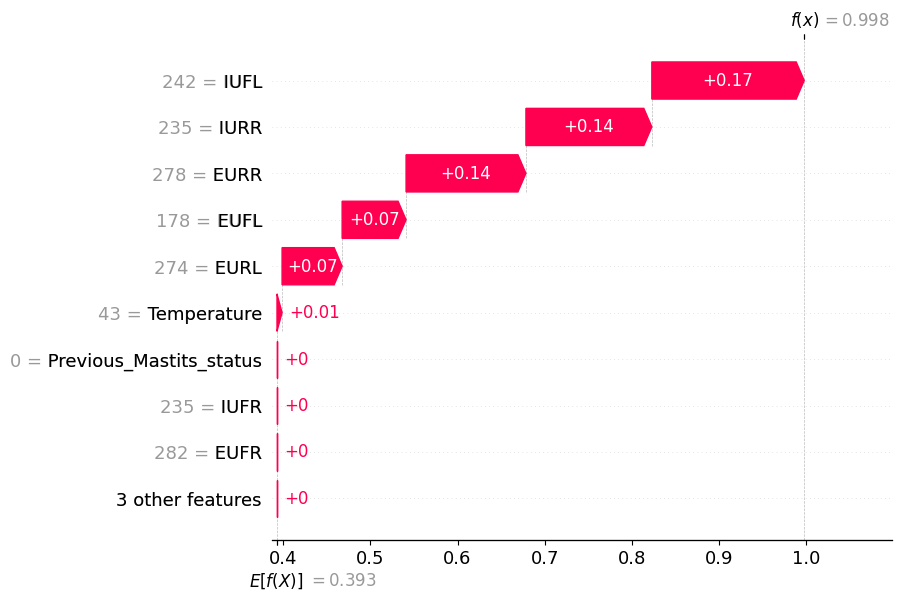

In [79]:
shap.plots.waterfall(shap_values_expl[0])